In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2022-07-29 10:00
# @Author  : zhangbowen

In [3]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import random
from utils.utils import normalization, standardization, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
# standardization (distribution -> mean=0, std=1, [0, 1]/[-1, 1])
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
# Normalization (distribution -> constant, [0, 1])
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

# 1. Data preparation

#### read row data

In [4]:
data_path = r'data/raw_utf-8.csv' 

df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
# list column names
column_names = df.columns.values.tolist()
# dataframe --> ndarray --> list
features = []
for i in range(len(column_names)):
    features.append(np.array(df[column_names[i]]))

In [5]:
df.shape

(89383, 316)

#### label selection

In [6]:
# feature 47: 現在_退職・休職区分 (0: 在職中, 1: 休職, 2: 退職, 3: その他; 82559 + 640 + 6184 = 89383)  
# feature 48: 現在_退職日
# feature 55: 回答日

##### 退職
date_turnover_all = features[48][features[47]==2]
date_answer_all = features[55][features[47]==2]
num_turnover = sum(features[47]==2) # 6184

intervals = []
for i in range(num_turnover):
    # answer date
    year_answer = int(date_answer_all[i][0:4])
    month_answer = int(date_answer_all[i][5:7])
    day_answer = int(date_answer_all[i][8:10])
    date_answer = datetime.datetime(year_answer, month_answer, day_answer) 
    # turnover date
    year_turnover = int(date_turnover_all[i][0:4])
    month_turnover = int(date_turnover_all[i][5:7])
    day_turnover = int(date_turnover_all[i][8:10])
    date_turnover = datetime.datetime(year_turnover, month_turnover, day_turnover) 
    # intervals
    intervals.append((date_turnover - date_answer).days)
    
# mode_intervals = stats.mode(intervals)[0][0]

id_label_1 = []
for i, interval in enumerate(intervals):
    if interval >=120 and interval <=150: # 346
        id_label_1.append(i)

label_1 = features[47][features[47]==2][id_label_1]

##### 在職中
num_label_0 = len(label_1) ########## 把在职设为与离职数量346相等 ##########
# num_label_0 = 346*9 ########## 自定义在职数量(maximum: 82559) ##########

tmp = [i for i in range(len(features[47][features[47]==0]))] # [0, 1, ..., 82557, 82558] 在職中: 82559
id_label_0 = random.sample(tmp, num_label_0) # [0, 1, ..., 82557, 82558]中的346/自定义`个
label_0 = features[47][features[47]==0][id_label_0]

#### label encoding

In [7]:
label_0[label_0==0] = 0 # 在職中
label_1[label_1==2] = 1 # 離職

new_label = np.hstack([label_0, label_1]) # num(在職) + 346(退職)

#### features selection

In [8]:
########## ojective features ##########
# 3: '業種大分類名称',
# 7: '性別',
# 9: '誕生年',　（現在 - 年齢）
# 11: '入社年',
# 13: '学歴名称',
# 15: '雇用形態名称',　（職位レベル）
# 19: '職種名称',
# 21: '個人年収名称',
# 25: '結婚名称',
# 197: 'B-216-999(毎日の通勤でストレスを感じる)',　（通勤距離）
# 198: 'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)',　（残業時間）


########## subjective features ##########
# 58: 'B-1-2(非常にたくさんの仕事をしなければならない)',　（疲れ）
# 64: 'B-7-27(からだを大変よく使う仕事だ)',
# 70: 'B-13-52(私の部署と他の部署とはうまが合わない)',
# 71: 'B-14-53(私の職場の雰囲気は友好的である)',　（同僚関係）
# 72: 'B-15-60(私の職場の作業環境（騒音、照明、温度、換気など）はよくない)',　（仕事環境）
# 74: 'B-17-65(働きがいのある仕事だ)',
# 133: 'B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している)',
# 136: 'B-79-313(仕事をしていると、活力がみなぎるように感じる)',
# 146: 'B-179-836(会社の成長や発展に自分が役に立ったことがある)',
# 201: 'B-220-1014(仕事以外にストレスを感じる原因となる事柄がある)',
# 205: 'B-224-1028(寝付きが悪い)',


########## 11 ojective + 11 subjective = 22 ##########
feature_ids = [3, 7, 9, 11, 13, 15, 19, 21, 25, 58, 64, 70, 71, 72, 74, 133, 136, 146, 197, 198, 201, 205]

new_features = []
for feature_id in feature_ids:
    feature = np.hstack([features[feature_id][features[47]==0][id_label_0], features[feature_id][features[47]==2][id_label_1]]) # num(在職) + 346(退職)
    new_features.append(feature)

#### summarize into a dataframe

In [9]:
# feature names
new_feature_names = []
for i in feature_ids:
    new_feature_names.append(column_names[i])

# label name
new_feature_names.append(column_names[47])

for i in range(len(new_features)):
    new_features[i] = new_features[i].reshape(-1, 1)

# features + label
new_features.append(new_label.reshape(-1, 1))
new_data = np.hstack(new_features)

# ndarray -> dataframe
new_df = pd.DataFrame(data=new_data, columns=new_feature_names)

#### new feature generation 

In [10]:
# 誕生年 -> 年齢
new_df['誕生年'] = 2021 - new_df['誕生年']

#### data type conversion

In [11]:
# japanese -> english
new_df = new_df.rename(columns={
    '業種大分類名称': 'Industry', 
    '性別': 'Gender',
    '誕生年': 'Age',
    '入社年': 'WorkingYear',
    '学歴名称': 'Education',
    '雇用形態名称': 'EmployeeLevel',
    '職種名称': 'EmployeeField',
    '個人年収名称': 'Annualsalary',
    '結婚名称': 'MaritalStatus',
    'B-216-999(毎日の通勤でストレスを感じる)': 'CompanyDistance',
    'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)': 'OverTime',
    'B-1-2(非常にたくさんの仕事をしなければならない)': 'WorkloadSatisfaction',
    'B-7-27(からだを大変よく使う仕事だ)': 'BodySatisfaction',
    'B-13-52(私の部署と他の部署とはうまが合わない)': 'DepartmentSatisfaction',
    'B-14-53(私の職場の雰囲気は友好的である)': 'CompanySatisfaction',
    'B-15-60(私の職場の作業環境（騒音、照明、温度、換気など）はよくない)': 'EnvironmentSatisfaction',
    'B-17-65(働きがいのある仕事だ)': 'WorthSatisfaction',
    'B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している)': 'LifeSatisfaction',
    'B-79-313(仕事をしていると、活力がみなぎるように感じる)': 'ActivitySatisfaction',
    'B-179-836(会社の成長や発展に自分が役に立ったことがある)': 'ProgressSatisfaction',
    'B-220-1014(仕事以外にストレスを感じる原因となる事柄がある)': 'LifePressureSatisfaction',
    'B-224-1028(寝付きが悪い)': 'SleepSatisfaction',
    '現在_退職・休職区分': 'Attrition'
})

# string -> int
# new_df['Age'] = pd.to_numeric(new_df['Age'], downcast='integer')
new_df[['Age', 'WorkingYear', 'CompanyDistance', 
       'OverTime', 'WorkloadSatisfaction', 'BodySatisfaction',
       'DepartmentSatisfaction', 'CompanySatisfaction', 'EnvironmentSatisfaction',
       'WorthSatisfaction', 'LifeSatisfaction', 'ActivitySatisfaction',
       'ProgressSatisfaction', 'LifePressureSatisfaction', 'SleepSatisfaction', 
       'Attrition']] = new_df[['Age', 'WorkingYear', 'CompanyDistance',
                               'OverTime', 'WorkloadSatisfaction', 'BodySatisfaction',
                               'DepartmentSatisfaction', 'CompanySatisfaction', 'EnvironmentSatisfaction',
                               'WorthSatisfaction', 'LifeSatisfaction', 'ActivitySatisfaction',
                               'ProgressSatisfaction', 'LifePressureSatisfaction', 'SleepSatisfaction',
                               'Attrition']].astype('int64')

# 2. Data analysis

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Industry                  692 non-null    object
 1   Gender                    692 non-null    object
 2   Age                       692 non-null    int64 
 3   WorkingYear               692 non-null    int64 
 4   Education                 687 non-null    object
 5   EmployeeLevel             687 non-null    object
 6   EmployeeField             687 non-null    object
 7   Annualsalary              685 non-null    object
 8   MaritalStatus             687 non-null    object
 9   WorkloadSatisfaction      692 non-null    int64 
 10  BodySatisfaction          692 non-null    int64 
 11  DepartmentSatisfaction    692 non-null    int64 
 12  CompanySatisfaction       692 non-null    int64 
 13  EnvironmentSatisfaction   692 non-null    int64 
 14  WorthSatisfaction         

#### category: count(=sum of not missing data), unique(=set), top(=category of highest frequency), freq(=highest frequency)

In [13]:
new_df.describe(include=['O'])

,Industry,Gender,Education,EmployeeLevel,EmployeeField,Annualsalary,MaritalStatus
count,692,692,687,687,687,685,687
unique,16,2,8,13,20,8,3
top,介護・福祉・医療,0,大学,正社員（一般）,営業,200～400万円未満,未婚
freq,147,385,290,360,108,276,365


#### numeri: count, mean, std, min, 25%, 50%, 75%, max

In [14]:
new_df.describe()

,Age,WorkingYear,WorkloadSatisfaction,BodySatisfaction,DepartmentSatisfaction,CompanySatisfaction,EnvironmentSatisfaction,WorthSatisfaction,LifeSatisfaction,ActivitySatisfaction,ProgressSatisfaction,CompanyDistance,OverTime,LifePressureSatisfaction,SleepSatisfaction,Attrition
count,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000
mean,38.221098,2014.346821,2.075145,2.588150,2.956647,1.946532,2.843931,2.115607,2.182081,2.267341,2.306358,2.911850,3.356936,2.634393,2.624277,0.500000
std,12.008992,7.615466,0.869230,1.078418,0.871397,0.800707,0.984059,0.846164,0.913841,0.890163,0.924855,1.014813,0.750144,1.002530,0.971603,0.500362
min,17.000000,1950.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,29.000000,2013.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,0.000000
50%,35.000000,2017.000000,2.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,3.000000,2.000000,0.500000
75%,46.000000,2019.000000,3.000000,4.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000
max,79.000000,2021.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


#### split features to category & numeric

In [15]:
category = [f for f in new_df.columns if new_df.dtypes[f] =='object'] 
numeric = [f for f in new_df.columns if new_df.dtypes[f] !='object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 7
numeric 16


#### relationship of numeric & label

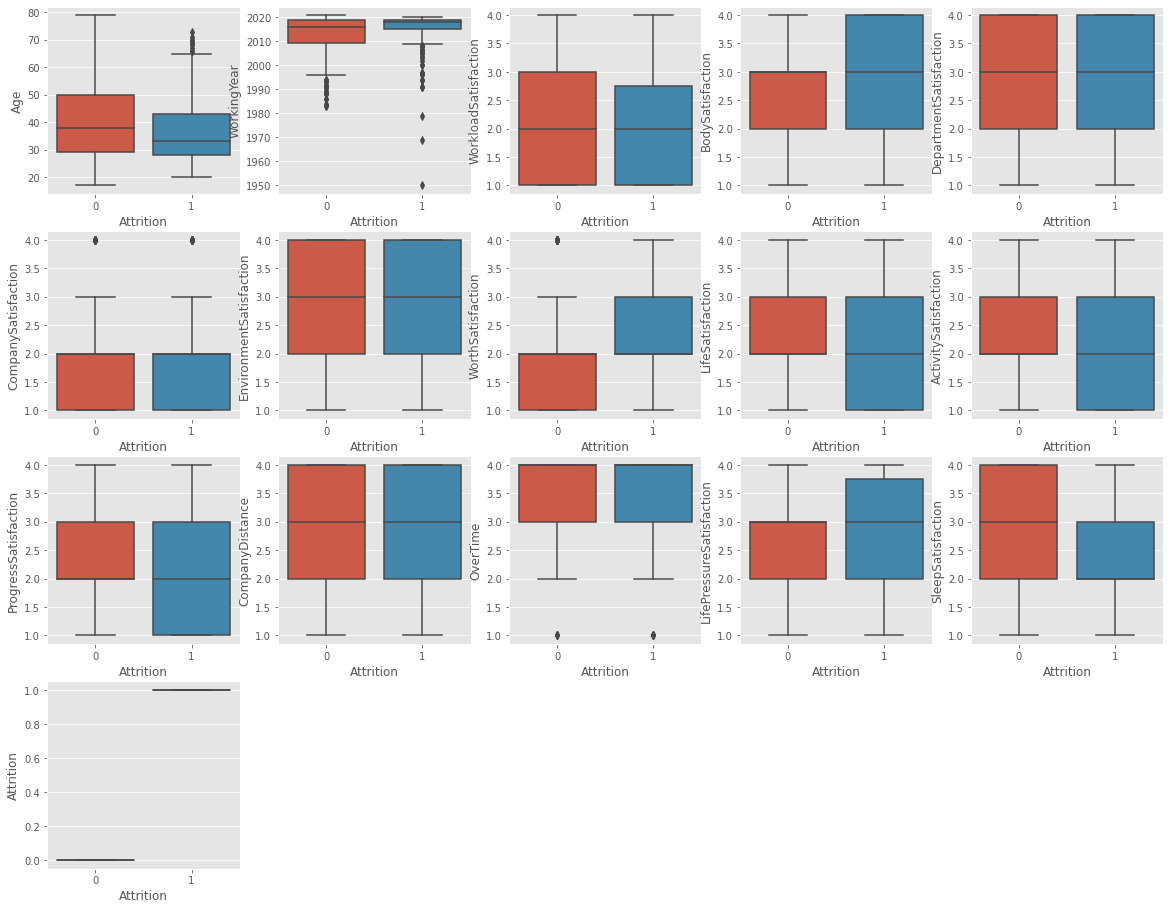

In [16]:
'''
sns.barplot() -> (mean)
sns.boxplot() -> (max, upper quartile, median, lower quartile, min)
sns.violinplot() -> (density distribution)
plt.scatter() -> (all datapoints)
sns.swarmplot -> (all datapoints)
'''
plt.figure(figsize=(20, 20))
for numeric_column in numeric:
    plt.subplot(5, 5, numeric.index(numeric_column)+1)
    sns.boxplot(data=new_df, x='Attrition', y=numeric_column)
plt.show()

#### distribution of numeric

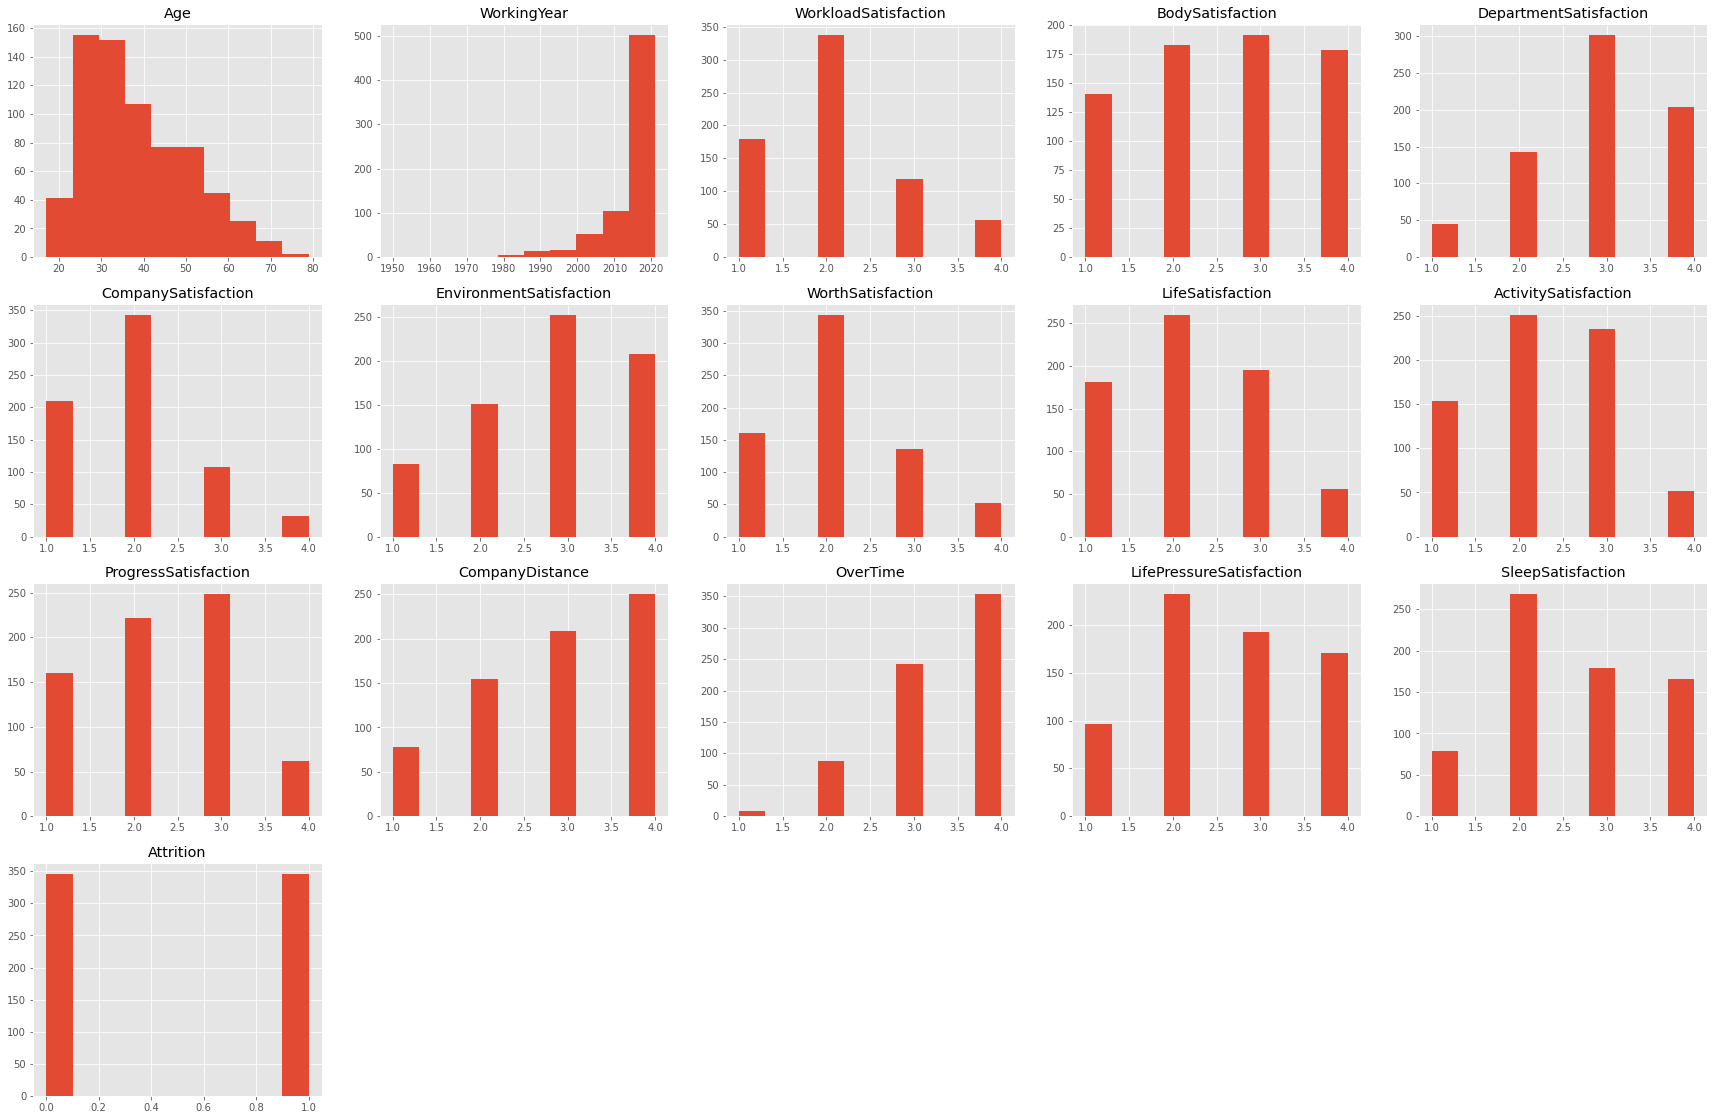

In [17]:
plt.figure(figsize=(30, 30))
for numeric_column in numeric:
    plt.subplot(6, 5, numeric.index(numeric_column)+1)
    plt.title(numeric_column)
    new_df[numeric_column].hist()
plt.show()

#### correlation coefficient of numeric & label

In [18]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = new_df[numeric_column]
    y = new_df['Attrition']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    print('{}: {:.2f}'.format(numeric_column, corrcoef))

Age: -0.14
WorkingYear: 0.17
WorkloadSatisfaction: 0.02
BodySatisfaction: 0.05
DepartmentSatisfaction: -0.03
CompanySatisfaction: 0.07
EnvironmentSatisfaction: -0.02
WorthSatisfaction: 0.13
LifeSatisfaction: -0.04
ActivitySatisfaction: -0.09
ProgressSatisfaction: -0.05
CompanyDistance: -0.04
OverTime: -0.02
LifePressureSatisfaction: 0.01
SleepSatisfaction: -0.11
Attrition: 1.00


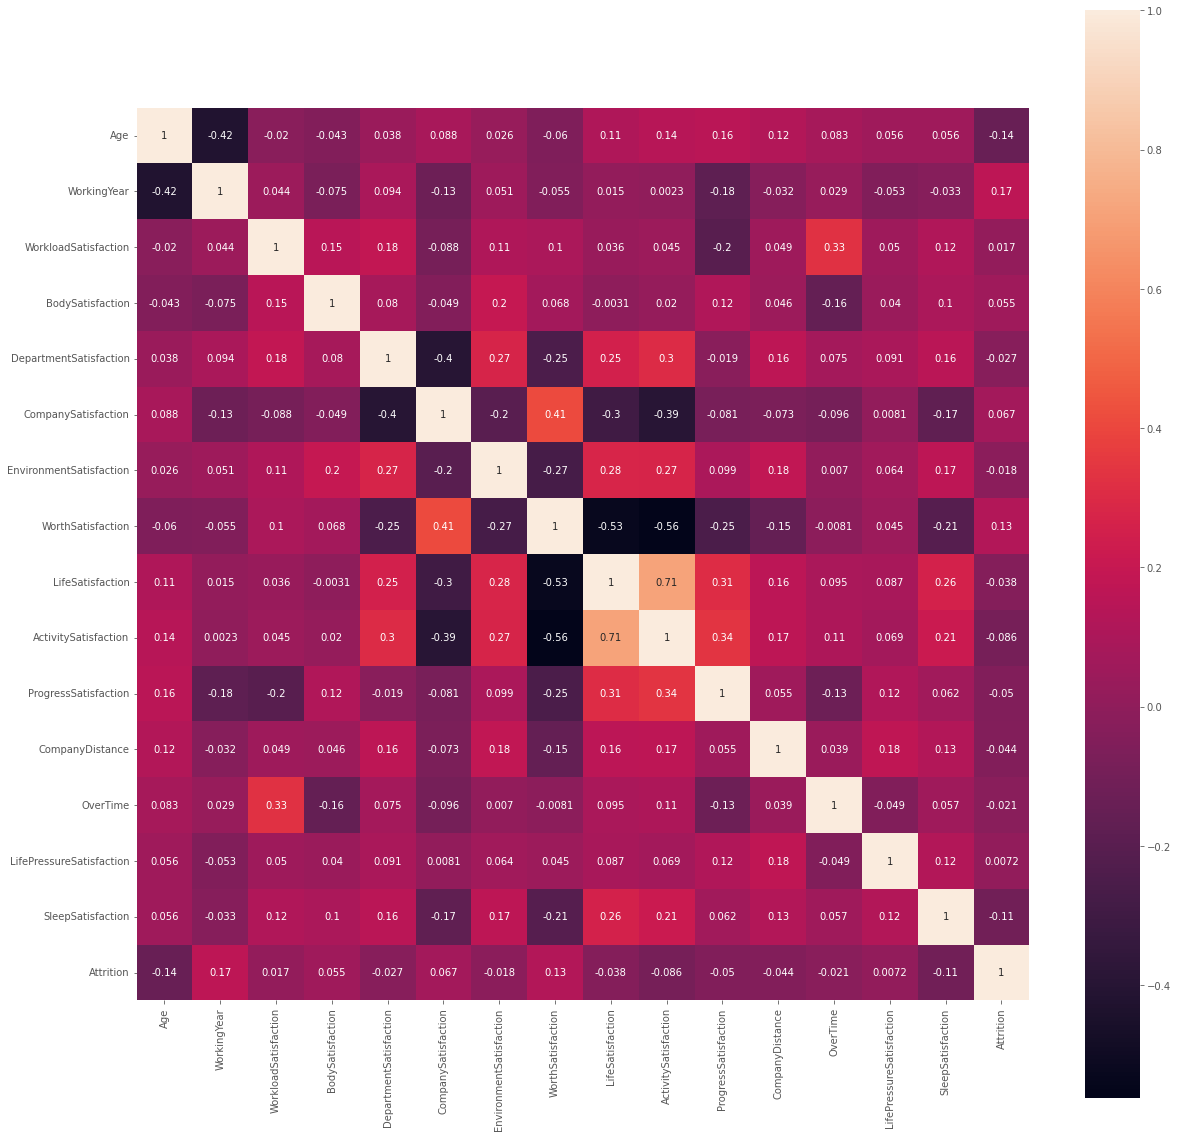

In [19]:
corrcoef_matrix = new_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrcoef_matrix, annot=True, square=True)
plt.show()

# 3. Data preprocessing

#### remove bad feature

In [20]:
new_df = new_df.drop(columns=['WorkingYear'])

#### outliers data

In [21]:
new_df.drop(new_df[new_df['Age']>65].index, inplace=True)

#### missing data

In [22]:
new_df.isnull().sum()

Industry                    0
Gender                      0
Age                         0
Education                   5
EmployeeLevel               5
EmployeeField               5
Annualsalary                7
MaritalStatus               5
WorkloadSatisfaction        0
BodySatisfaction            0
DepartmentSatisfaction      0
CompanySatisfaction         0
EnvironmentSatisfaction     0
WorthSatisfaction           0
LifeSatisfaction            0
ActivitySatisfaction        0
ProgressSatisfaction        0
CompanyDistance             0
OverTime                    0
LifePressureSatisfaction    0
SleepSatisfaction           0
Attrition                   0
dtype: int64

In [23]:
# e.g. check various types of MaritalStatus category
new_df['MaritalStatus'].value_counts()

未婚        361
既婚        257
答えたくない     51
Name: MaritalStatus, dtype: int64

In [24]:
# fill via mode
for column in ['Education', 'EmployeeLevel', 'EmployeeField']:
    # mode
    mode = stats.mode(new_df[column])[0][0]
    print(mode)
    new_df[column].fillna(mode, inplace=True)

大学
正社員（一般）
営業


In [25]:
new_df['Annualsalary'][new_df['Annualsalary']=='100万円未満'] = 0
new_df['Annualsalary'][new_df['Annualsalary']=='100～200万円未満'] = 1
new_df['Annualsalary'][new_df['Annualsalary']=='200～400万円未満'] = 2
new_df['Annualsalary'][new_df['Annualsalary']=='400～700万円未満'] = 3
new_df['Annualsalary'][new_df['Annualsalary']=='700～1000万円未満'] = 4
new_df['Annualsalary'][new_df['Annualsalary']=='1000～1500万円未満'] = 5
new_df['Annualsalary'][new_df['Annualsalary']=='1500万円以上'] = 6
# median
median = new_df['Annualsalary'][(new_df['Annualsalary'].notnull()) 
                                 & (new_df['Annualsalary']!='分からない・答えたくない')].median()
print(median)
# fill via median
new_df['Annualsalary'].fillna(median, inplace=True)
# '分からない・答えたくない' -> median
new_df['Annualsalary'][new_df['Annualsalary']=='分からない・答えたくない'] = median

2.0


In [26]:
# fill via '未婚'
new_df['MaritalStatus'].fillna('未婚', inplace=True)
# '答えたくない' -> '未婚'
new_df['MaritalStatus'][new_df['MaritalStatus']=='答えたくない'] = '未婚'

In [27]:
new_df.isnull().sum()

Industry                    0
Gender                      0
Age                         0
Education                   0
EmployeeLevel               0
EmployeeField               0
Annualsalary                0
MaritalStatus               0
WorkloadSatisfaction        0
BodySatisfaction            0
DepartmentSatisfaction      0
CompanySatisfaction         0
EnvironmentSatisfaction     0
WorthSatisfaction           0
LifeSatisfaction            0
ActivitySatisfaction        0
ProgressSatisfaction        0
CompanyDistance             0
OverTime                    0
LifePressureSatisfaction    0
SleepSatisfaction           0
Attrition                   0
dtype: int64

#### distribution of numeric (whether skewness)

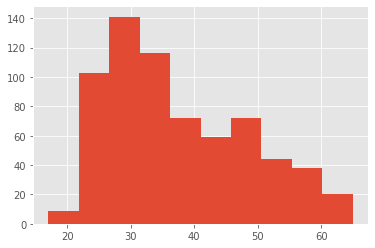

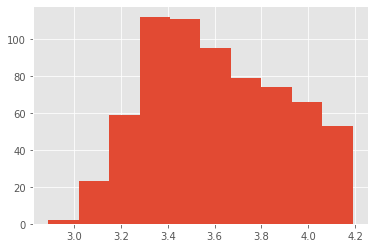

In [28]:
'''
right/positively skewed distribution(mode < median <mean): use np.log1p()
left/negatively skewed distribution(mean < median < mode): use np.expm1()
'''
new_df['Age'].hist()
plt.show()

new_df['Age'] = np.log1p(new_df['Age'])
new_df['Age'].hist()
plt.show()

#### standardization & normalization of numeric

In [29]:
scaler = MinMaxScaler()
norm_list = ['Age', 'WorkloadSatisfaction', 'BodySatisfaction',
             'DepartmentSatisfaction', 'CompanySatisfaction', 'EnvironmentSatisfaction',
             'WorthSatisfaction', 'LifeSatisfaction', 'ActivitySatisfaction',
             'ProgressSatisfaction', 'CompanyDistance', 'OverTime',
             'LifePressureSatisfaction', 'SleepSatisfaction']
for column in norm_list:
    new_df[column] = scaler.fit_transform(new_df[column].values.reshape(-1, 1))  

# df_norm = new_df
# norm_list = ['Age']
# for column in norm_list:
#     df_norm['Age'.format(column)] = scaler.fit_transform(new_df[column].values.reshape(-1, 1))
# new_df = df_norm.drop(norm_list, axis='columns')

In [30]:
new_df.describe()

,Age,WorkloadSatisfaction,BodySatisfaction,DepartmentSatisfaction,CompanySatisfaction,EnvironmentSatisfaction,WorthSatisfaction,LifeSatisfaction,ActivitySatisfaction,ProgressSatisfaction,CompanyDistance,OverTime,LifePressureSatisfaction,SleepSatisfaction,Attrition
count,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,0.552297,0.357072,0.533136,0.651830,0.315529,0.613749,0.373393,0.389713,0.417903,0.431751,0.636004,0.781405,0.539565,0.539070,0.498516
std,0.216876,0.288627,0.358818,0.292062,0.267086,0.329100,0.281880,0.304259,0.295700,0.308443,0.339540,0.251179,0.334324,0.323337,0.500369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367067,0.000000,0.333333,0.333333,0.000000,0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.666667,0.333333,0.333333,0.000000
50%,0.533484,0.333333,0.666667,0.666667,0.333333,0.666667,0.333333,0.333333,0.333333,0.333333,0.666667,1.000000,0.666667,0.333333,0.000000
75%,0.738697,0.666667,1.000000,1.000000,0.333333,1.000000,0.666667,0.666667,0.666667,0.666667,1.000000,1.000000,0.666667,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### category outliers

In [31]:
# check various types of each category 
category = [f for f in new_df.columns if new_df.dtypes[f] =='object'] 

for column in category:
    print('**********'+column+'**********')
    print(new_df[column].value_counts())
    print('*'*40)

**********Industry**********
介護・福祉・医療             136
サービス                 101
IT・インターネット            91
コンサルティング              56
広告・マスコミ・エンターテイメント     49
建設・不動産                44
メーカー（電気・電子・機械）        39
人材サービス                36
金融・保険                 31
小売・流通                 26
インフラ                  17
運輸・物流                 14
メーカー（素材・食品・医薬品他）      14
商社                    13
教育・研修                  6
士業                     1
Name: Industry, dtype: int64
****************************************
**********Gender**********
0    374
1    300
Name: Gender, dtype: int64
****************************************
**********Education**********
大学               293
高等学校             146
専門学校             126
短期大学              41
大学院               28
高等専門学校・高等専修学校     17
中学校               12
その他               11
Name: Education, dtype: int64
****************************************
**********EmployeeLevel**********
正社員（一般）               363
正社員（係長・主任・課長補佐クラス）     91
パート／アルバイト              88
正社員（課長ク

In [32]:
new_df.drop(new_df[new_df['Industry']=='士業'].index, inplace=True)
new_df.drop(new_df[new_df['Industry']=='教育・研修'].index, inplace=True)
new_df.drop(new_df[new_df['Industry']=='その他'].index, inplace=True)

new_df.drop(new_df[new_df['Education']=='その他'].index, inplace=True)

new_df.drop(new_df[new_df['EmployeeLevel']=='出向／業務委託'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeLevel']=='その他'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeLevel']=='経営者・役員'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeLevel']=='嘱託社員（再雇用）'].index, inplace=True)

new_df.drop(new_df[new_df['EmployeeField']=='軽作業'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeField']=='輸送・機械運転'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeField']=='警備・設備管理等'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeField']=='建設・土木技術職'].index, inplace=True)
new_df.drop(new_df[new_df['EmployeeField']=='事務'].index, inplace=True)

new_df.drop(new_df[new_df['Annualsalary']==6].index, inplace=True)

#### category encoding (one-hot, ordinary, frequency, ..., etc.)

In [33]:
# only category features
new_df_category = new_df[category]
new_df_category

,Industry,Gender,Education,EmployeeLevel,EmployeeField,Annualsalary,MaritalStatus
0,介護・福祉・医療,1,専門学校,正社員（一般）,営業,2.0,未婚
1,サービス,1,大学,正社員（一般）,サービス(販売以外),2.0,未婚
2,サービス,1,高等専門学校・高等専修学校,正社員（一般）,サービス(販売以外),2,未婚
3,IT・インターネット,0,大学,正社員（一般）,ITエンジニア,2.0,未婚
4,IT・インターネット,0,高等学校,正社員（一般）,販売,2,未婚
...,...,...,...,...,...,...,...
687,メーカー（電気・電子・機械）,0,専門学校,正社員（一般）,その他,3,未婚
688,メーカー（電気・電子・機械）,0,専門学校,正社員（一般）,その他,3,未婚
689,メーカー（電気・電子・機械）,0,大学院,正社員（一般）,技術職(機械・電子・電気・半導体等),3,未婚
690,メーカー（電気・電子・機械）,0,大学院,正社員（一般）,技術職(機械・電子・電気・半導体等),3,未婚


#### one-hot encoding

In [34]:
data_dummies = pd.get_dummies(new_df_category)
data_dummies

,Industry_IT・インターネット,Industry_インフラ,Industry_コンサルティング,Industry_サービス,Industry_メーカー（素材・食品・医薬品他）,Industry_メーカー（電気・電子・機械）,Industry_人材サービス,Industry_介護・福祉・医療,Industry_商社,Industry_小売・流通,...,EmployeeField_管理部門,EmployeeField_販売,Annualsalary_0.0,Annualsalary_1.0,Annualsalary_2.0,Annualsalary_3.0,Annualsalary_4.0,Annualsalary_5.0,MaritalStatus_既婚,MaritalStatus_未婚
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
688,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
689,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
690,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [35]:
# merge one-hot & numeric
final_df = pd.concat((new_df.drop(list(new_df_category), axis='columns'), data_dummies), axis=1)
final_df

,Age,WorkloadSatisfaction,BodySatisfaction,DepartmentSatisfaction,CompanySatisfaction,EnvironmentSatisfaction,WorthSatisfaction,LifeSatisfaction,ActivitySatisfaction,ProgressSatisfaction,...,EmployeeField_管理部門,EmployeeField_販売,Annualsalary_0.0,Annualsalary_1.0,Annualsalary_2.0,Annualsalary_3.0,Annualsalary_4.0,Annualsalary_5.0,MaritalStatus_既婚,MaritalStatus_未婚
0,0.831166,1.000000,0.000000,0.333333,0.333333,0.000000,1.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,1
1,0.554572,0.333333,1.000000,1.000000,0.666667,1.000000,0.000000,0.333333,0.666667,0.333333,...,0,0,0,0,1,0,0,0,0,1
2,0.770770,0.333333,0.666667,1.000000,0.000000,0.666667,0.333333,0.333333,0.333333,0.000000,...,0,0,0,0,1,0,0,0,0,1
3,0.340059,0.000000,1.000000,0.666667,0.333333,1.000000,0.333333,0.333333,0.000000,1.000000,...,0,0,0,0,1,0,0,0,0,1
4,0.188660,0.000000,1.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.333333,0.666667,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0.801560,0.333333,1.000000,1.000000,0.333333,0.666667,0.333333,0.333333,0.333333,0.333333,...,0,0,0,0,0,1,0,0,0,1
688,0.801560,0.333333,0.666667,0.666667,0.333333,0.666667,0.333333,0.333333,0.333333,0.333333,...,0,0,0,0,0,1,0,0,0,1
689,0.489492,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,...,0,0,0,0,0,1,0,0,0,1
690,0.489492,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,...,0,0,0,0,0,1,0,0,0,1


#### move labels to last column

In [36]:
pop_df = final_df.pop('Attrition')
final_df.insert(final_df.shape[1], pop_df.name, pop_df)

# 4. Feature selection

#### check feature importance via Lasso

feature importance via Lasso
                          Feature Importance
Industry_インフラ                       0.370177
EmployeeLevel_パート／アルバイト             0.309579
EmployeeLevel_派遣社員                  0.278987
EmployeeField_クリエイティブ               0.235272
Industry_メーカー（電気・電子・機械）             0.189360
...                                      ...
Annualsalary_1.0                   -0.104488
SleepSatisfaction                  -0.145227
EmployeeLevel_正社員（課長クラス）           -0.236380
Age                                -0.242629
EmployeeField_未入力                  -0.418257

[69 rows x 1 columns]


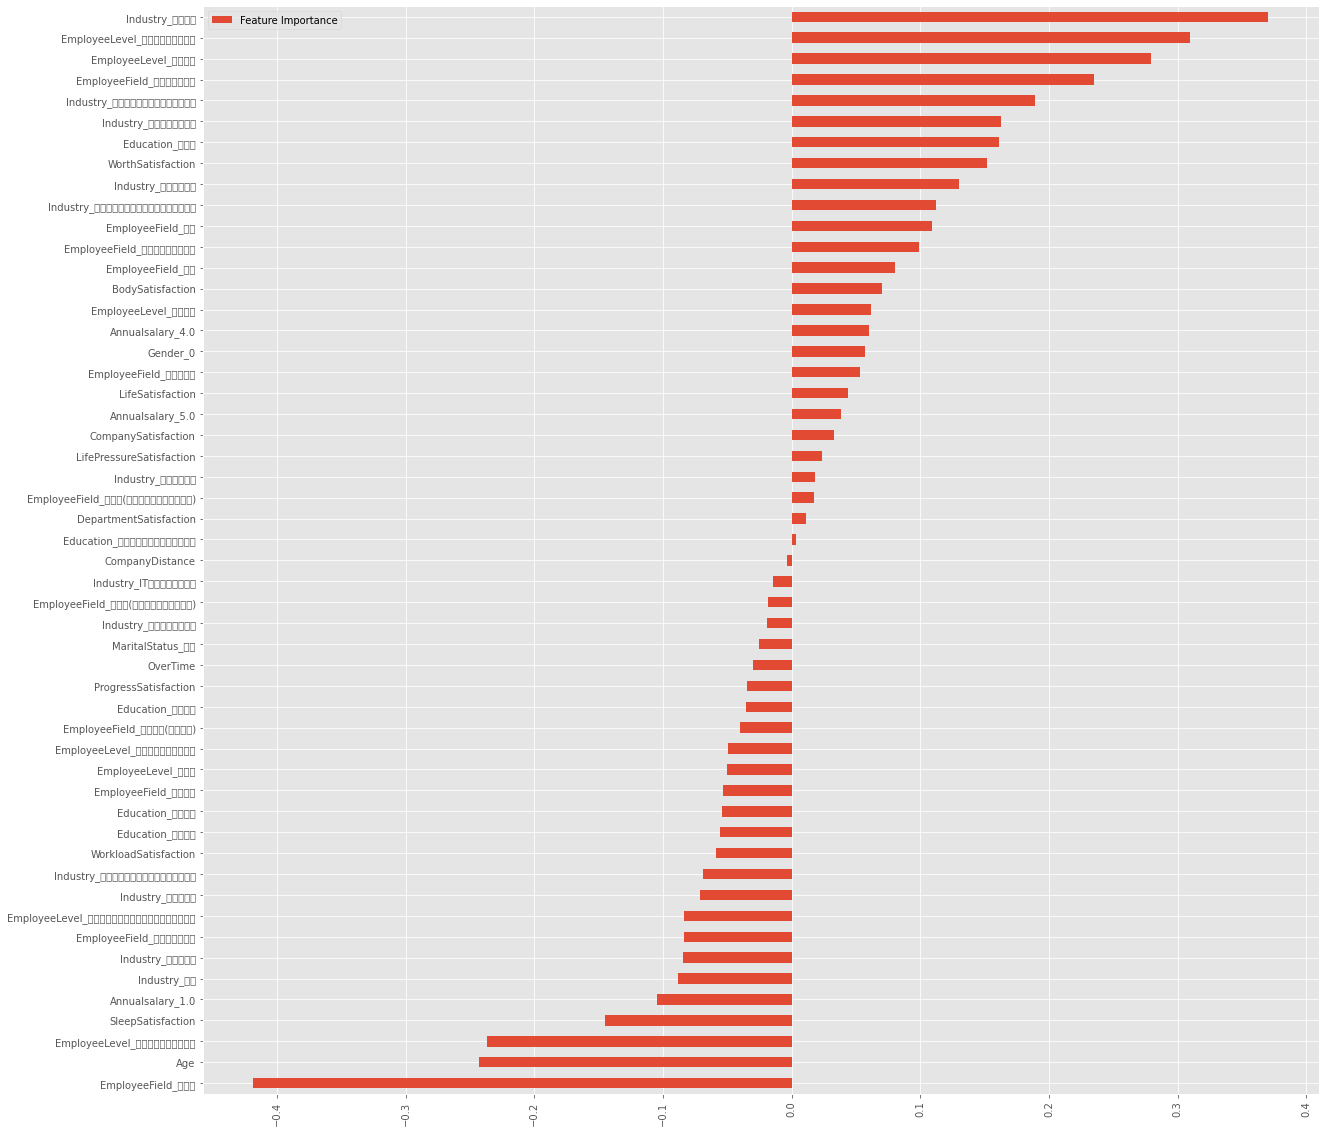

In [37]:
lasso=Lasso(alpha=0.001) # if alpha is so large, coefficients tend to become 0
lasso.fit(final_df.iloc[:, 0:-1], final_df.iloc[:, -1])

FI_lasso = pd.DataFrame({'Feature Importance':lasso.coef_}, index=final_df.columns[0: -1])
print('feature importance via Lasso')
# rank feature importance
print(FI_lasso.sort_values('Feature Importance', ascending=False))
# visualize feature importance
FI_lasso[FI_lasso['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh', figsize=(20, 20))
plt.xticks(rotation=90)
plt.show()

#### select only top n features to use

In [38]:
threshold = 0.05

ranked_features = FI_lasso.sort_values('Feature Importance', ascending=False)['Feature Importance']
selected_features = []
for key, value in ranked_features.items():
    if value >= threshold:
        selected_features.append(key)
    else:
        break
len(selected_features)

18

In [39]:
selected_features.append('Attrition')
final_df = final_df[selected_features]
final_df

,Industry_インフラ,EmployeeLevel_パート／アルバイト,EmployeeLevel_派遣社員,EmployeeField_クリエイティブ,Industry_メーカー（電気・電子・機械）,Industry_コンサルティング,Education_大学院,WorthSatisfaction,Industry_人材サービス,Industry_広告・マスコミ・エンターテイメント,EmployeeField_販売,EmployeeField_介護・福祉サービス,EmployeeField_営業,BodySatisfaction,EmployeeLevel_契約社員,Annualsalary_4.0,Gender_0,EmployeeField_医療専門職,Attrition
0,0,0,0,0,0,0,0,1.000000,0,0,0,0,1,0.000000,0,0,0,0,0
1,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,1.000000,0,0,0,0,0
2,0,0,0,0,0,0,0,0.333333,0,0,0,0,0,0.666667,0,0,0,0,0
3,0,0,0,0,0,0,0,0.333333,0,0,0,0,0,1.000000,0,0,1,0,0
4,0,0,0,0,0,0,0,0.666667,0,0,1,0,0,1.000000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0,0,0,0,1,0,0,0.333333,0,0,0,0,0,1.000000,0,0,1,0,1
688,0,0,0,0,1,0,0,0.333333,0,0,0,0,0,0.666667,0,0,1,0,1
689,0,0,0,0,1,0,1,0.666667,0,0,0,0,0,0.333333,0,0,1,0,1
690,0,0,0,0,1,0,1,0.333333,0,0,0,0,0,0.333333,0,0,1,0,1


# 5. label balance

#### current balance

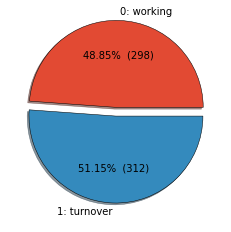

In [40]:
a = final_df.loc[final_df['Attrition']==0].count()[0]
b = final_df.loc[final_df['Attrition']==1].count()[0]
values = [a, b]
labels = ['0: working', '1: turnover']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### downsampling (already done in 'label selection' cell)

#### upsampling (only needed)


In [41]:
# # remove label from features
# columns = final_df.columns
# features_columns = columns
# features = final_df[features_columns]
# labels = final_df['Attrition']
# train_data, val_data, train_label, val_label = train_test_split(features, labels, test_size=0.2, random_state=1234)

# # feed features $ labels into sampler
# sampler = RandomOverSampler(random_state=1234)
# sample_features, sample_labels = sampler.fit_resample(train_data, train_label)

# # datapoints number
# len(sample_features)                                                             

In [42]:
# a = sample_features.loc[sample_features['Attrition']==0].count()[0]
# b = sample_features.loc[sample_features['Attrition']==1].count()[0]
# values = [a, b]
# labels = ['0: working', '1: turnover']
# explode = [0.1, 0]

# def make_autopct(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct*total/100.0))
#         return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
#     return my_autopct
# plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
# plt.show()

In [43]:
# sns.countplot('Attrition', data=sample_features)
# len(sample_features[sample_features['Attrition']==0]), len(sample_features[sample_features['Attrition']==1])

#### dataframe -> csv

In [44]:
# original number of data
final_df.to_csv('data/Attrition/data_utf-8.csv', index=False) # index=False: no write index
# upsampled data
# sample_features.to_csv('data/data_utf-8.csv', index=True)

# 6. Load &  split data for training 

#### read pre-processed data

In [45]:
data_path = r'data/Attrition/data_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
df.describe()

,Industry_インフラ,EmployeeLevel_パート／アルバイト,EmployeeLevel_派遣社員,EmployeeField_クリエイティブ,Industry_メーカー（電気・電子・機械）,Industry_コンサルティング,Education_大学院,WorthSatisfaction,Industry_人材サービス,Industry_広告・マスコミ・エンターテイメント,EmployeeField_販売,EmployeeField_介護・福祉サービス,EmployeeField_営業,BodySatisfaction,EmployeeLevel_契約社員,Annualsalary_4.0,Gender_0,EmployeeField_医療専門職,Attrition
count,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,0.022951,0.132787,0.011475,0.021311,0.059016,0.086885,0.040984,0.377596,0.049180,0.075410,0.036066,0.134426,0.180328,0.533880,0.031148,0.049180,0.542623,0.062295,0.511475
std,0.149870,0.339623,0.106594,0.144539,0.235849,0.281898,0.198415,0.282121,0.216422,0.264268,0.186606,0.341390,0.384776,0.360977,0.173859,0.216422,0.498589,0.241889,0.500279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### split dataframe -> features & label -> train & test

In [46]:
features = df.iloc[:, 0:-1]
label = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1234, stratify=label)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((488, 18), (122, 18), (488,), (122,))

# 7. PCA

In [47]:
# # model
# pca = PCA(n_components=2, random_state=1234)
# # train
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# X_train_pca.shape, X_test_pca.shape

#### visualize PC distribution

In [48]:
# def scatterPlot(xDF, yDF, first_PC, second_PC, algoName):
#     tempDF = pd.DataFrame(data=pd.concat((xDF.loc[:,first_PC], xDF.loc[:,second_PC]), axis=1, join="inner"), index=xDF.index)
#     # tempDF = pd.DataFrame(data=xDF.loc[:,first_PC:second_PC], index=xDF.index)
#     tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
#     tempDF.columns = ["First Vector", "Second Vector", "Label"]
#     sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
#                data=tempDF, fit_reg=False)
#     ax = plt.gca()
#     ax.set_title("Separation of Observations via "+algoName)

# # ndarray -> dataframe for visualization
# df_X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)
# scatterPlot(df_X_train_pca, y_train, 0, 1, 'PCA')

In [49]:
# X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape

# 8. Modeling

#### regression

In [50]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
# from sklearn.svm import SVR, LinearSVR
# from sklearn.kernel_ridge import KernelRidge
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor


# models = [LinearRegression(), Ridge(), Lasso(alpha=0.01,max_iter=10000), RandomForestRegressor(), GradientBoostingRegressor(), 
#           SVR(), LinearSVR(), ElasticNet(alpha=0.001,max_iter=10000), SGDRegressor(max_iter=1000,tol=1e-3), BayesianRidge(),
#           KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5), ExtraTreesRegressor(), XGBRegressor()
# ]

# names = ['LR', 'Ridge', 'Lasso', 'RF', 'GBR', 
#          'SVR', 'LinSVR', 'Ela', 'SGD', 'Bay', 
#          'Ker', 'Extra', 'Xgb'
# ]

#### classification

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


models = [LogisticRegression(), DecisionTreeClassifier(), SVC(), LinearSVC(), XGBClassifier(),
          KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), ExtraTreesClassifier()
]

names = ['LogisticRegression', 'DecisionTreeClassifier', 'SVC', 'LinearSVC', 'XGBClassifier', 
         'KNeighborsClassifier', 'GaussianNB', 'RandomForestClassifier', 'ExtraTreesClassifier'
]

#### score function (K-folds)

In [52]:
num_folds = 5

def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=num_folds)

    return acc


def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision_weighted', cv=num_folds)

    return precision


def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall_weighted', cv=num_folds)

    return recall


def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1_weighted', cv=num_folds)

    return f1_score

# 9. Evaluation (train)

In [54]:
for name, model in zip(names, models):
    # evaluator
    score = recall_cv(model, X_train, y_train)
    print('||{}||     mean sore: {:.4f},     std score: {:.4f}'.format(name, score.mean(), score.std()))

||LogisticRegression||     mean sore: 0.6228,     std score: 0.0311
||DecisionTreeClassifier||     mean sore: 0.5553,     std score: 0.0373
||SVC||     mean sore: 0.6127,     std score: 0.0285
||LinearSVC||     mean sore: 0.6351,     std score: 0.0418
||XGBClassifier||     mean sore: 0.5471,     std score: 0.0459
||KNeighborsClassifier||     mean sore: 0.5881,     std score: 0.0434
||GaussianNB||     mean sore: 0.5367,     std score: 0.0457
||RandomForestClassifier||     mean sore: 0.5532,     std score: 0.0375
||ExtraTreesClassifier||     mean sore: 0.5553,     std score: 0.0407


# 10. Hyperparameters Tuning (Grid Search)

In [55]:
num_folds = 5
metrics = 'precision_weighted'
# metrics = ['precision_weighted', 'recall_weighted']

class GridSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=num_folds, scoring=metrics)
        grid_search.fit(X, y)
        
        print(grid_search.best_params_, grid_search.best_score_)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

#### DecisionTreeClassifier

In [56]:
# GridSearch(LogisticRegression()).grid_get(X_train, y_train, {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})        

param_grid = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

GridSearch(DecisionTreeClassifier()).grid_get(X_train, y_train, param_grid)        

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 4, 'splitter': 'random'} 0.6371207697731707


#### XGBClassifier

In [56]:
# GridSearch(SVC()).grid_get(X_train, y_train, {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

# GridSearch(LinearSVC()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

param_grid = {'eta':[0.01, 0.1, 1.0],
              'gamma':[0, 0.1], 
              'n_estimators':[10, 100],
              'max_depth':[2, 4], 
              'min_child_weigh':[1, 2],
              'nthread':[2]
}

GridSearch(XGBClassifier(verbosity=0)).grid_get(X_train, y_train, param_grid)

# GridSearch(KNeighborsClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

# GridSearch(GaussianNB()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

# GridSearch(RandomForestClassifier()).grid_get(X_train, y_train, param_grid)

# GridSearch(ExtraTreesClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'eta': 1.0, 'gamma': 0.1, 'max_depth': 2, 'min_child_weigh': 1, 'n_estimators': 100, 'nthread': 2} 0.6000232213132453


# 11. model combination

# 12. Evaluation (test)